Intention of this notebook is to create Neural Network, but using only torch.tensor as building block, implement every other module from scratch.

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.init as init
import torch.nn.functional as F


In [2]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


# Reading Data

In [3]:
data = pd.read_csv('fashion-mnist/fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist/fashion-mnist_test.csv')

#data = pd.concat([train, test], axis=0)

#data.to_csv('fashion-mnist/net_fashion_mnist_data.csv', index=False)

#data = pd.read_csv('fashion-mnist/net_fashion_mnist_data.csv')


In [4]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
label_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}


## Visualizing some sample images

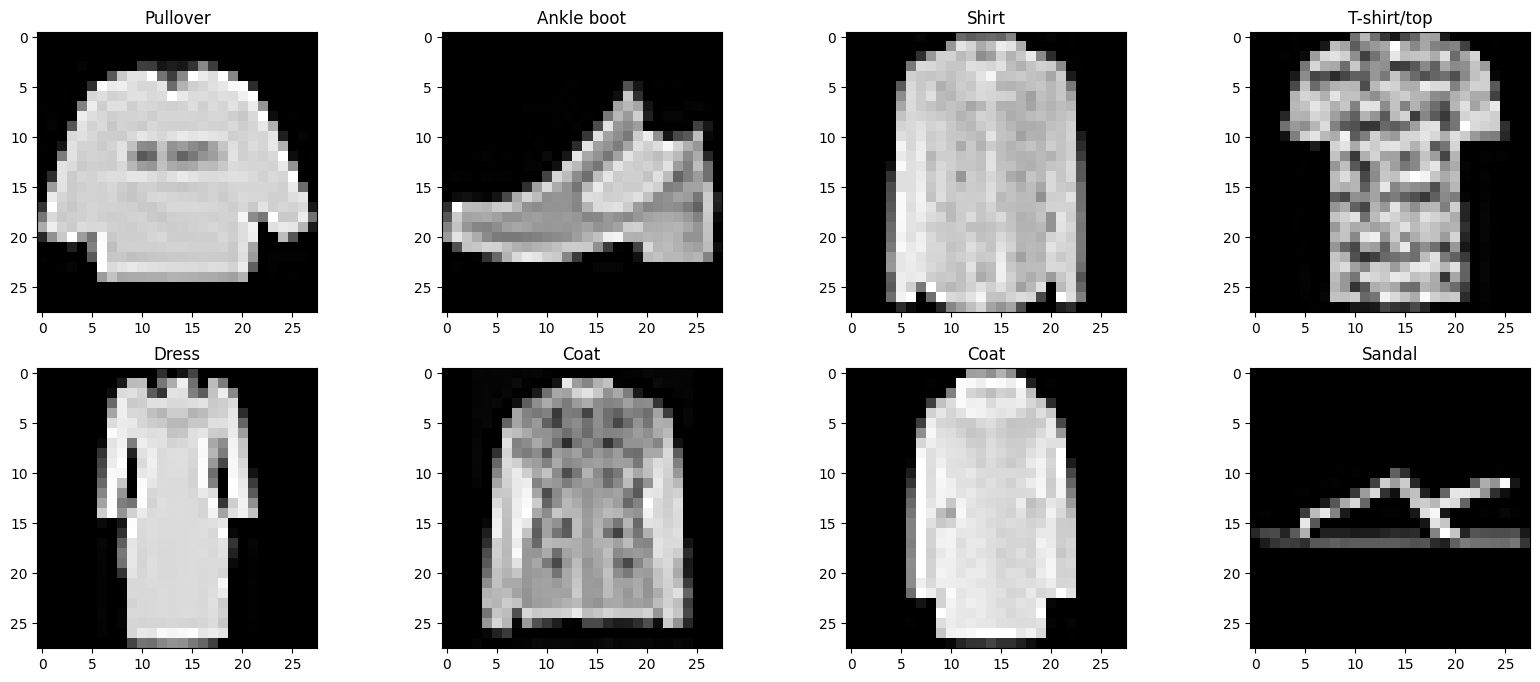

In [6]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i in range(8):
	ax[i//4, i%4].imshow(data.iloc[i, 1:].values.reshape(28, 28), cmap='gray')
	ax[i//4, i%4].set_title(label_dict[data.iloc[i, 0]])

In [7]:
features = data.iloc[:, 1:].values
target = data.iloc[:, 0].values

features_tensor = torch.tensor(features, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.int64)

In [8]:
np.unique(target, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [9]:
test_features = test.iloc[:, 1:].values
test_target = test.iloc[:, 0].values

test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_target_tensor = torch.tensor(test_target, dtype=torch.int64)

# Starting with Architecture (non OOPS way)

In [10]:
### Defining all the parameters

w1 = torch.randn((784, 40), requires_grad=True) 
torch.nn.init.xavier_normal_(w1)

b1 = torch.randn((1, 40), requires_grad=True)

w2 = torch.randn((40, 40), requires_grad=True)
torch.nn.init.xavier_normal_(w2)

b2 = torch.randn((1, 40), requires_grad=True)


w3 = torch.randn((40, 40), requires_grad=True)
torch.nn.init.xavier_normal_(w3)

b3 = torch.randn((1, 40), requires_grad=True)

w4 = torch.randn((40, 40), requires_grad=True)
torch.nn.init.xavier_normal_(w4)

b4 = torch.randn((1, 40), requires_grad=True)

w5 = torch.randn((40, 10), requires_grad=True)
torch.nn.init.xavier_normal_(w5)

b5 = torch.randn((1, 10), requires_grad=True)


parameters = [w1, b1, w2, b2, w3, b3, w4, b4, w5, b5]


In [11]:
def relu(x):
	x =  torch.clamp(x, min=0)
	return x

#def softmax(logits):
#	exp_logits = torch.exp(logits)
#	sum_exp_logits = exp_logits.sum(axis=1, keepdims=True)
#	#print("shape sum_exp_logits: ", sum_exp_logits.shape)
#	return exp_logits/sum_exp_logits

def softmax(logits):
	logits_max = logits.max(dim=1, keepdim=True)[0]  # Max per sample
	shifted_logits = logits - logits_max  # Stabilize
	exp_logits = torch.exp(shifted_logits)


	#exp_logits = torch.exp(logits)
	sum_exp_logits = exp_logits.sum(dim=1, keepdim=True)
	return exp_logits / sum_exp_logits

	
def categorical_cce(y_actual, y_pred):
	y_pred = torch.clamp(y_pred, min=1e-7, max=1-1e-7) 
	log_probs = torch.log(y_pred[torch.arange(len(y_pred)), y_actual])
	loss = -log_probs.mean()
	return loss
	

In [12]:
out_layer1 = features_tensor @ w1 + b1
act_out_layer1 = relu(out_layer1)

out_layer2 = act_out_layer1 @ w2 + b2
act_out_layer2 = relu(out_layer2)

out_layer3 = act_out_layer2 @ w3 + b3
act_out_layer3 = relu(out_layer3)

out_layer4 = act_out_layer3 @ w4 + b4
act_out_layer4 = relu(out_layer4)

out_layer5 = act_out_layer4 @ w5 + b5



In [13]:
out_layer5.max(dim=1, keepdim=True)

torch.return_types.max(
values=tensor([[41.2109],
        [30.4248],
        [70.4286],
        ...,
        [68.4819],
        [41.8208],
        [21.0240]], grad_fn=<MaxBackward0>),
indices=tensor([[3],
        [7],
        [7],
        ...,
        [7],
        [6],
        [6]]))

In [14]:
def fwd_pass():

	out_layer1 = features_tensor @ w1 + b1
	act_out_layer1 = relu(out_layer1)

	out_layer2 = act_out_layer1 @ w2 + b2
	act_out_layer2 = relu(out_layer2)

	out_layer3 = act_out_layer2 @ w3 + b3
	act_out_layer3 = relu(out_layer3)

	out_layer4 = act_out_layer3 @ w4 + b4
	act_out_layer4 = relu(out_layer4)

	out_layer5 = act_out_layer4 @ w5 + b5
	act_out_layer5 = softmax(out_layer5)

	return act_out_layer5

In [15]:

#epochs = 200


#for p in parameters:
#	p.grad = None


#for epoch in range(epochs):

#	output = fwd_pass()

#	loss = categorical_cce(target_tensor, output)

#	loss.backward()

#	for p in parameters:
#		#print(f"Parameter: {p}, grad: {p.grad.item():.4f}")
#		p.data -= 0.001 * p.grad
#		p.grad = None

#	if epoch % 10 == 0:
#		print(f"For epoch: {epoch}, loss is: {loss:.3f}")



	


# Starting with Architecture (OOPS way)

In [16]:
features_tensor.shape

torch.Size([60000, 784])

In [17]:
target_tensor.shape

torch.Size([60000])

In [18]:
class Linear:
	def __init__(self, no_of_features, no_of_neurons, bias=True):
		#self.w = torch.randn((no_of_features, no_of_neurons))
		self.w = torch.nn.init.kaiming_normal_(torch.empty((no_of_features, no_of_neurons)), nonlinearity='linear')

		self.b = torch.zeros(no_of_neurons) if bias else None

		

	def __call__(self, x):

		self.out = torch.matmul(x, self.w)
		if self.b is not None:
			self.out += self.b

		return self.out
	
	def parameters(self):
		return [self.w] + [self.b] if self.b is not None else []
	
class BatchNorm:
	
	def __init__(self, dim, eps=1e-6, momentum=0.1):
		self.eps = eps
		self.momentum = momentum

		self.running_mean = torch.zeros(dim)
		self.running_var = torch.ones(dim)

		self.gamma = torch.ones(dim) # try with ones later, see diff
		self.beta = torch.zeros(dim)

		self.training = True

	
	def __call__(self, x):

		if self.training:
		
			mean = x.mean(dim=0, keepdim=True)
			var = x.var(dim=0, keepdim=True)
		else:
			mean = self.running_mean
			var = self.running_var



		out = (x - mean)/torch.sqrt(var + self.eps)

		self.out = self.gamma * out + self.beta

		if self.training:
			with torch.no_grad():
				self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
				self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var

		return self.out
	
	def parameters(self):
		return [self.gamma, self.beta]
	

class Tanh:
	
	def __call__(self, x):
		self.out = torch.tanh(x)
		return self.out
	
	def parameters(self):
		return []
	

class Relu:
    
    def __call__(self, x):
        self.out = torch.relu(x)
        return self.out
    
    def parameters(self):
        return []
	

class Softmax:
	
	def __call__(self, x):
		logits_max = x.max(dim=1, keepdim=True)[0]
		logits = x - logits_max
		exp_logits = torch.exp(logits)


		#exp_logits = torch.exp(x)

		
		sum_exp_logits = exp_logits.sum(dim=1, keepdim=True)

		self.out = exp_logits/sum_exp_logits

		return self.out
	
	def parameters(self):
		return []
	


def categorical_cce(y_actual, y_pred):
	y_pred = torch.clamp(y_pred, min=1e-7, max=1-1e-7) 
	log_probs = torch.log(y_pred[torch.arange(len(y_pred)), y_actual])
	loss = -log_probs.mean()
	return loss


#def softmax(logits):
#	logits_max = logits.max(dim=1, keepdim=True)[0]  # Max per sample
#	shifted_logits = logits - logits_max  # Stabilize
#	exp_logits = torch.exp(shifted_logits)


#	#exp_logits = torch.exp(logits)
#	sum_exp_logits = exp_logits.sum(dim=1, keepdim=True)
#	return exp_logits / sum_exp_logits

	
#def categorical_cce(y_actual, y_pred):
#	y_pred = torch.clamp(y_pred, min=1e-7, max=1-1e-7) 
#	log_probs = torch.log(y_pred[torch.arange(len(y_pred)), y_actual])
#	loss = -log_probs.mean()
#	return loss
	


In [19]:
dim = features_tensor.shape[1]
n_hidden = 100
layers = [
	Linear(dim, n_hidden, bias=True), BatchNorm(n_hidden), Tanh(),
	Linear(n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
	Linear(n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
	Linear(n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
	Linear(n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
	Linear(n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Tanh(),
	Linear(n_hidden, 10, bias=False), Softmax()
]

#layers = [
#	Linear(dim, n_hidden, bias=True), BatchNorm(n_hidden), Relu(),
#	Linear(n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Relu(),
#	Linear(n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Relu(),
#	Linear(n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Relu(),
#	Linear(n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Relu(),
#	Linear(n_hidden, n_hidden, bias=False), BatchNorm(n_hidden), Relu(),
#	Linear(n_hidden, 10, bias=False), Softmax()
#]



parameters = [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters)) # number of parameters in total


for p in parameters:
	p.requires_grad = True


79700


In [20]:
import torch
epochs = 300


for p in parameters:
	p.grad = None


for epoch in range(epochs):

	#output = fwd_pass()
	#output  = layers(features_tensor)

	x = features_tensor

	for layer in layers:
		x = layer(x)
		layer.out.retain_grad()

	for p in parameters:
		p.grad = None

	# Assuming your target labels are stored in `targets` and your predicted logits are stored in `logits`
	loss = F.cross_entropy(x, target_tensor)
	#loss = categorical_cce(target_tensor, x)

	loss.backward()


	for p in parameters:
		#print(f"Parameter: {p}, grad: {p.grad.item():.4f}")
		p.data -= 0.1 * p.grad
		

	if epoch % 10 == 0:
		# checking performance on test

		tx = test_features_tensor
		for layer in layers:
			tx = layer(tx)

		# compute accuracy
		accuracy = (tx.argmax(dim=1) == test_target_tensor).float().mean()
		print(f"For epoch: {epoch}, loss is: {loss:.3f}" + f' test accuracy: {accuracy.item():.2%}')



For epoch: 0, loss is: 2.309 test accuracy: 13.39%
For epoch: 10, loss is: 2.183 test accuracy: 29.79%
For epoch: 20, loss is: 2.094 test accuracy: 39.70%
For epoch: 30, loss is: 2.014 test accuracy: 48.48%
For epoch: 40, loss is: 1.968 test accuracy: 52.79%
For epoch: 50, loss is: 1.934 test accuracy: 56.38%
For epoch: 60, loss is: 1.909 test accuracy: 58.80%
For epoch: 70, loss is: 1.890 test accuracy: 60.50%
For epoch: 80, loss is: 1.876 test accuracy: 61.80%
For epoch: 90, loss is: 1.864 test accuracy: 63.37%
For epoch: 100, loss is: 1.853 test accuracy: 64.53%
For epoch: 110, loss is: 1.843 test accuracy: 65.61%
For epoch: 120, loss is: 1.833 test accuracy: 66.63%
For epoch: 130, loss is: 1.824 test accuracy: 67.27%
For epoch: 140, loss is: 1.816 test accuracy: 68.20%
For epoch: 150, loss is: 1.809 test accuracy: 68.95%
For epoch: 160, loss is: 1.803 test accuracy: 69.45%
For epoch: 170, loss is: 1.797 test accuracy: 70.02%
For epoch: 180, loss is: 1.791 test accuracy: 70.37%
For 

layer 2 (      Tanh): mean +0.00, std 0.64, saturated: 2.86%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.50%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.56%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.63%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.68%
layer 17 (      Tanh): mean -0.00, std 0.64, saturated: 3.03%


Text(0.5, 1.0, 'activation distribution')

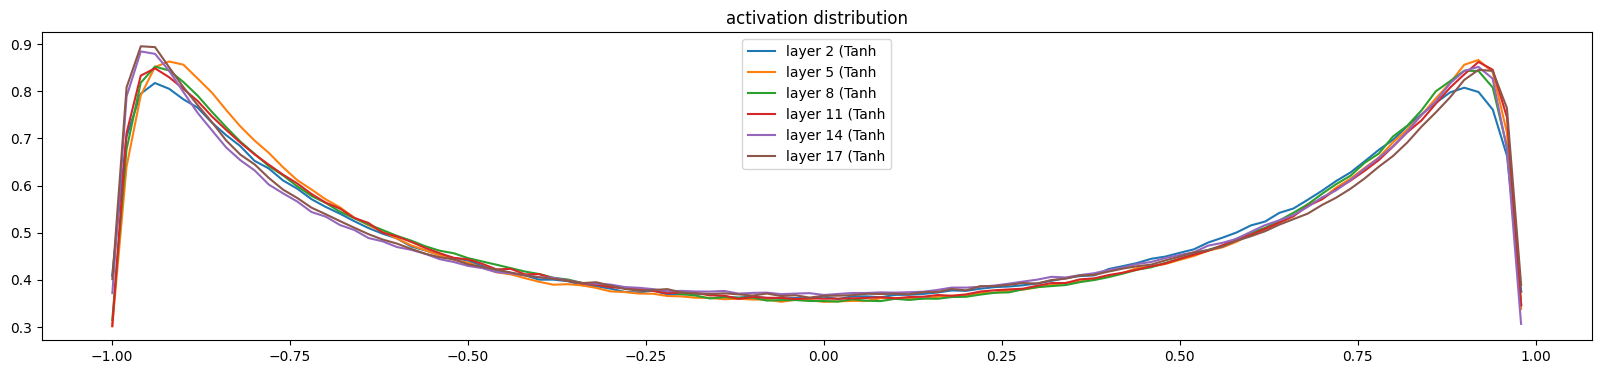

In [21]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
  #if isinstance(layer, Relu):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [22]:
## visualize histograms
#plt.figure(figsize=(20, 4)) # width and height of the plot
#legends = []
#for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
#  if isinstance(layer, Tanh):
#  #if isinstance(layer, Relu):
    
#    t = layer.out.grad
#    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
#    hy, hx = torch.histogram(t, density=True)
#    plt.plot(hx[:-1].detach(), hy.detach())
#    legends.append(f'layer {i} ({layer.__class__.__name__}')
#plt.legend(legends);
#plt.title('gradient distribution')

weight (784, 100) | mean -0.000005 | std 2.133348e-04 | grad:data ratio 2.132408e-03
weight     (100,) | mean +0.000000 | std 6.810168e-13 | grad:data ratio 5.296076e-01
weight     (100,) | mean +0.000020 | std 5.061122e-04 | grad:data ratio 3.257181e-02
weight     (100,) | mean -0.000021 | std 4.379942e-04 | grad:data ratio 2.944804e-02
weight     (100,) | mean +0.000061 | std 5.448119e-04 | grad:data ratio 2.926495e-02
weight     (100,) | mean +0.000034 | std 4.492069e-04 | grad:data ratio 3.284741e-02
weight     (100,) | mean +0.000093 | std 5.130114e-04 | grad:data ratio 3.096765e-02
weight     (100,) | mean -0.000022 | std 4.013061e-04 | grad:data ratio 2.744297e-02
weight     (100,) | mean +0.000061 | std 4.119945e-04 | grad:data ratio 2.582647e-02
weight     (100,) | mean -0.000055 | std 4.205731e-04 | grad:data ratio 3.156174e-02
weight     (100,) | mean +0.000062 | std 5.044801e-04 | grad:data ratio 2.905077e-02
weight     (100,) | mean +0.000054 | std 5.071881e-04 | grad:data

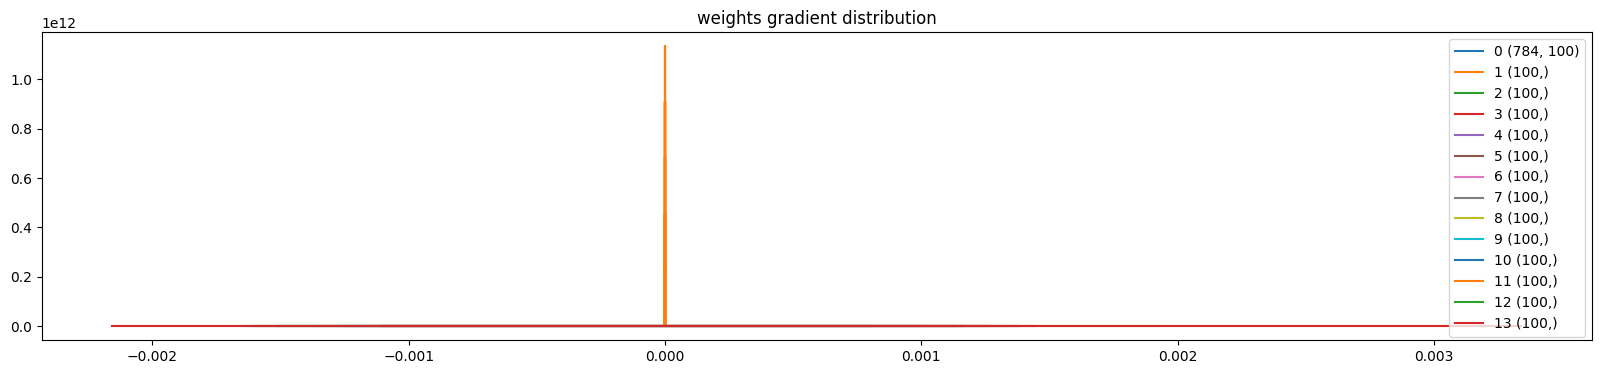

In [23]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  #if p.ndim == 2:
  print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
  hy, hx = torch.histogram(t, density=True)
  plt.plot(hx[:-1].detach(), hy.detach())
  legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

# Commencing Inference

In [24]:
# checking performance on test

x = test_features_tensor
for layer in layers:
	x = layer(x)

# compute accuracy
accuracy = (x.argmax(dim=1) == test_target_tensor).float().mean()
print(f'accuracy: {accuracy.item():.2%}')

accuracy: 76.30%


In [25]:
for layer in layers:
  layer.training = False


4


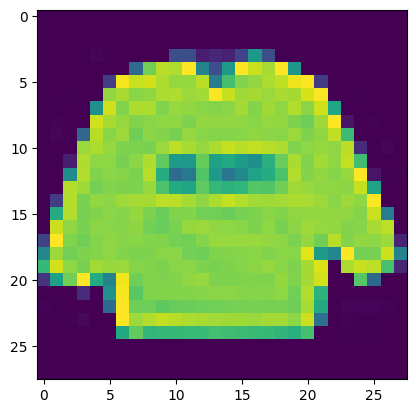

In [26]:
inp =  features_tensor[0].reshape(1, -1)
inp.shape


x = inp

for layer in layers:
	x = layer(x)

plt.imshow(inp.reshape((28, 28)))
print(torch.argmax(x, dim=1).item())

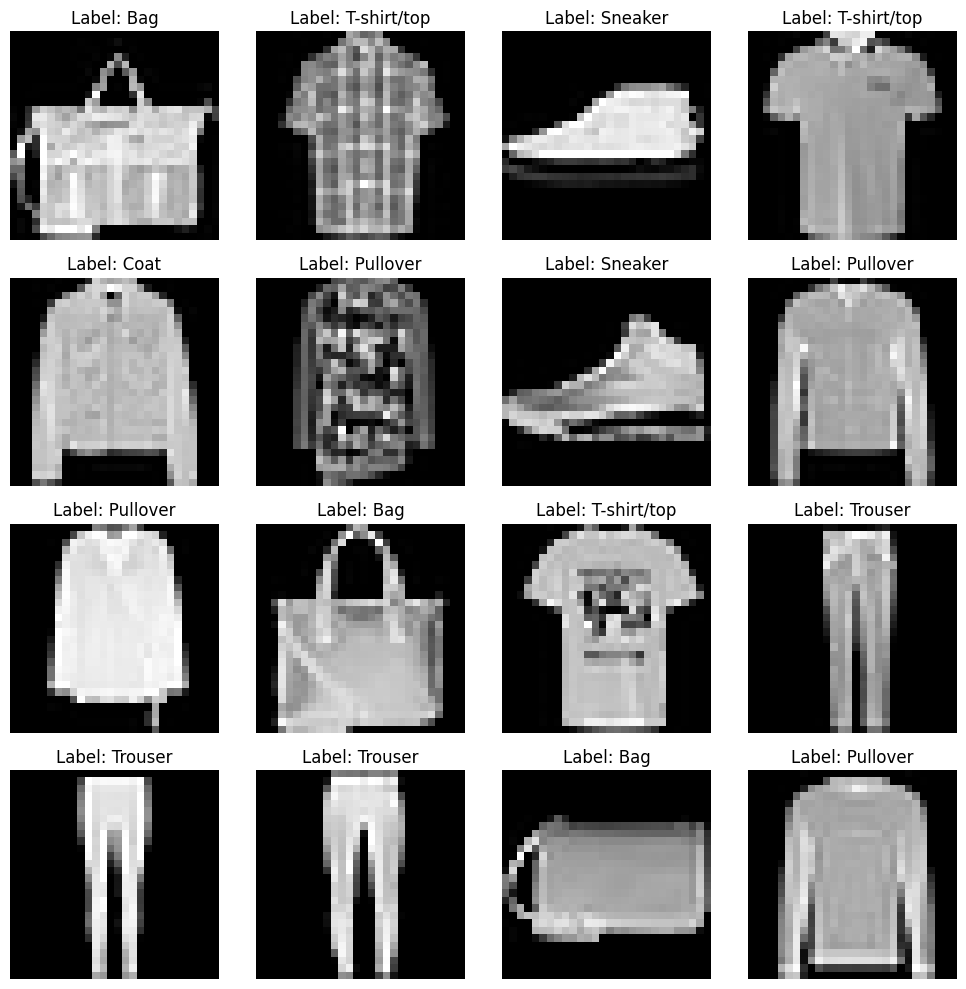

In [27]:
import matplotlib.pyplot as plt
import torch
import random

# Assuming features_tensor and layers are already defined

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    # Randomly sample an image
    idx = random.randint(0, len(features_tensor) - 1)
    inp = features_tensor[idx].reshape(1, -1)
    
    # Forward pass through the network
    x = inp
    for layer in layers:
        x = layer(x)
    
    # Get the predicted label
    label = torch.argmax(x, dim=1).item()
    
    # Display the image
    ax.imshow(inp.reshape((28, 28)), cmap='gray')
    ax.set_title(f'Label: {label_dict[label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()